<a href="https://colab.research.google.com/github/konkuk-gaegul/3rd-Team-Project/blob/main/Pytorch_dachshund.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 닥스훈트 학습
- 9개 이미지 전처리 중, 가장 좋은 성능인 set 9을 대표로 업로드
- Loss : 0.1858, Acc : 95.56%

## 이미지 전처리 설명
**set_1**
- 이미지 크기, 선명하게, 스케일링

**set_2**
- 이미지 크기, 선명하게, 대비향상, 스케일링

**set_3**
- 이미지 크기, 흑백, 선명하게, 대비향상, 이진화, 스케일링

**set_4**
- 이미지크기, 대비향상(RGB적용X), 스케일링

**set_5**
- 이미지크기, 양방향필터, 이진화, 스케일링

**set_6**
- 대비향상(YUV 적용), 선명도, 이미지크기x, 스케일링x

**set_7**
- 이미지크기, 배경제거(높이150), 스케일링x

**set_8**
- 이미지크기, 선명도, 배경제거(높이180), 스케일링x

**set_9**
- 정방형자르기, 대비향상(YUV 적용), 선명도, 스케일링x

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time

import copy
import os, shutil
import matplotlib as plt

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

In [ ]:
for i in range(9, 10):
    base_dir = '/home/tutor/안재형/dog_pic/닥스훈트'
    base_folder = os.path.join(base_dir, f'set_{i}')
    # # 훈련셋, 검증셋, 테스트셋을 미리 분할하기 위한 폴더 경로
    train_path = os.path.join(base_folder, 'train')
    os.mkdir( train_path)

    test_path = os.path.join(base_folder, 'test')
    os.mkdir( test_path)

    # # train 정상 폴더
    train_nor_path = os.path.join(train_path, 'nor')
    os.mkdir( train_nor_path)

    # # train 비만 폴더
    train_fat_path = os.path.join(train_path, 'fat')
    os.mkdir( train_fat_path)

    # # test 정상 폴더
    test_nor_path = os.path.join(test_path, 'nor')
    os.mkdir( test_nor_path)

    # # test 비만 폴더
    test_fat_path = os.path.join(test_path, 'fat')
    os.mkdir( test_fat_path)
    
    nor_path = os.path.join(base_folder, '전처리_정상')
    fat_path = os.path.join(base_folder, '전처리_비만')

    nor_list = os.listdir(nor_path)
    fat_list = os.listdir(fat_path)
    print(f'닥스훈트 set_{i}')
    print(len(nor_list))
    print(len(fat_list))
    print('---------')
    
    # train : 75%, test : 25%
    # 정상 이미지 복사
    for i in range(len(nor_list)):
        src_path = os.path.join(nor_path, nor_list[i])

        if i < len(nor_list)*0.75:
            dst_path = os.path.join(train_nor_path, f'nor_{i}.jpg')
            shutil.copyfile( src_path, dst_path )
        else :
            dst_path = os.path.join(test_nor_path, f'nor_{i}.jpg')
            shutil.copyfile( src_path, dst_path )

    # 비만 이미지 복사
    for i in range(len(fat_list)):
        src_path = os.path.join(fat_path, fat_list[i])

        if i < len(fat_list)*0.75:
            dst_path = os.path.join(train_fat_path, f'fat_{i}.jpg')
            shutil.copyfile( src_path, dst_path )
        else :
            dst_path = os.path.join(test_fat_path, f'fat_{i}.jpg')
            shutil.copyfile( src_path, dst_path )

닥스훈트 set_9
698
299
---------


# 학습 1
- set_9 이미지 사용
- batch_size를 5 ~ 14까지 반복, 최적의 성능을 찾는다.
- 이미지 증식 활용
- epoch = 50, 100, 150 각 3번 반복

In [ ]:
# Loss_Accuracy에 각 배치 사이즈마다의 성능을 넣어둔다
Loss_Accuracy = []

In [ ]:
epochs = [50, 100, 150]
for i in range(9, 10):
    # set 9에서 j 번 째 학습을 의미
    for j in range(1, 10):
        # 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
        # 이미지의 밝기(brightness), 대비(contrast), 채도(saturation), 색조(hue)를 일부 변경
        transforms_train = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
        ])

        transforms_test = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        data_dir = '/home/tutor/안재형/dog_pic/닥스훈트'
        data_folder = os.path.join(data_dir, f'set_{i}')
        train_datasets = datasets.ImageFolder(os.path.join(data_folder, 'train'), transforms_train)
        test_datasets = datasets.ImageFolder(os.path.join(data_folder, 'test'), transforms_test)

        train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=10, shuffle=True, num_workers=2)
        test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=10, shuffle=True, num_workers=2)

#         print('학습 데이터셋 크기:', len(train_datasets))
#         print('테스트 데이터셋 크기:', len(test_datasets))

        class_names = train_datasets.classes
#         print('클래스:', class_names)

        #--------------------------------------------#

        model = models.resnet34(pretrained=True)
        num_features = model.fc.in_features
        # 전이 학습(transfer learning): 모델의 출력 뉴런 수를 2개로 교체하여 마지막 레이어 다시 학습
        model.fc = nn.Linear(num_features, 2)
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

        #--------------------------------------------#
        print(f'-------------현재 set_{i} {j}번째 학습-------------')
        num_epochs = epochs[j % 3]  # 1,2,0 , ...
        model.train()
        start_time = time.time()

        # 전체 반복(epoch) 수 만큼 반복하며
        for epoch in range(num_epochs):
            running_loss = 0.
            running_corrects = 0

            # 배치 단위로 학습 데이터 불러오기
            for inputs, labels in train_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 모델에 입력(forward)하고 결과 계산
                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(train_datasets)
            epoch_acc = running_corrects / len(train_datasets) * 100.

            # 학습 과정 중에 결과 출력
            print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

        #--------------------------------------------#

        model.eval()
        start_time = time.time()

        with torch.no_grad():
            running_loss = 0.
            running_corrects = 0

            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
                print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
    #             imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

            epoch_loss = running_loss / len(test_datasets)
            epoch_acc = running_corrects / len(test_datasets) * 100.
            print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

            Loss_Accuracy.append([i, j, epoch_loss, epoch_acc])
        
        # 8*10개 모든 모델을 저장하지 않고 가장 좋은 성능의 모델을 저장
        if j == 1:
            Best = [j, epoch_loss, epoch_acc]
            # 닥스훈트 set i / j 번째 학습 1인 경우를 의미
            torch.save(model, f'dac_set{i}_{j}_1.pth')

        elif epoch_loss < Best[2]:
            # Best 모델보다 Loss가 개선되면 저장
            Best = [j, epoch_loss, epoch_acc]
            # 가장 마지막으로 저장된 모델이 제일 좋은 성능
            torch.save(model, f'dac_set{i}_{j}_1.pth')
        print(f'현재 Best는 epoch : {epoch+1} / iteration : {Best[0]}번째 / Loss : {Best[1]} ')
#         print('--------------------------------------------------')

-------------현재 set_9 1번째 학습-------------
#0 Loss: 0.5076 Acc: 77.1696% Time: 6.2050s
#1 Loss: 0.3333 Acc: 86.1148% Time: 12.0777s
#2 Loss: 0.1885 Acc: 91.4553% Time: 17.9526s
#3 Loss: 0.1847 Acc: 92.3899% Time: 23.6676s
#4 Loss: 0.1641 Acc: 93.1909% Time: 29.4080s
#5 Loss: 0.0852 Acc: 97.0628% Time: 35.1261s
#6 Loss: 0.1400 Acc: 95.8612% Time: 40.7812s
#7 Loss: 0.0977 Acc: 96.3952% Time: 46.8197s
#8 Loss: 0.0543 Acc: 98.3979% Time: 52.8643s
#9 Loss: 0.0827 Acc: 97.1963% Time: 58.7087s
#10 Loss: 0.0563 Acc: 98.2644% Time: 64.7057s
#11 Loss: 0.0699 Acc: 97.1963% Time: 70.6908s
#12 Loss: 0.0841 Acc: 97.5968% Time: 76.5371s
#13 Loss: 0.0268 Acc: 99.1989% Time: 82.3722s
#14 Loss: 0.0475 Acc: 98.1308% Time: 88.2384s
#15 Loss: 0.0185 Acc: 99.5995% Time: 94.0205s
#16 Loss: 0.0368 Acc: 99.0654% Time: 99.7465s
#17 Loss: 0.0215 Acc: 99.1989% Time: 105.9130s
#18 Loss: 0.0314 Acc: 98.7984% Time: 111.7504s
#19 Loss: 0.0160 Acc: 99.7330% Time: 117.6201s
#20 Loss: 0.0123 Acc: 99.7330% Time: 123.5577s

#57 Loss: 0.0077 Acc: 99.7330% Time: 337.6022s
#58 Loss: 0.0045 Acc: 99.8665% Time: 343.5396s
#59 Loss: 0.0067 Acc: 99.7330% Time: 349.5651s
#60 Loss: 0.0199 Acc: 99.3324% Time: 355.3036s
#61 Loss: 0.0043 Acc: 100.0000% Time: 361.1434s
#62 Loss: 0.0019 Acc: 100.0000% Time: 366.9815s
#63 Loss: 0.0020 Acc: 100.0000% Time: 372.7931s
#64 Loss: 0.0015 Acc: 100.0000% Time: 378.8665s
#65 Loss: 0.0021 Acc: 100.0000% Time: 384.6168s
#66 Loss: 0.0012 Acc: 100.0000% Time: 390.2200s
#67 Loss: 0.0009 Acc: 100.0000% Time: 396.0092s
#68 Loss: 0.0009 Acc: 100.0000% Time: 401.9595s
#69 Loss: 0.0070 Acc: 99.7330% Time: 407.9967s
#70 Loss: 0.0040 Acc: 99.8665% Time: 413.7629s
#71 Loss: 0.0012 Acc: 100.0000% Time: 419.7039s
#72 Loss: 0.0106 Acc: 99.4660% Time: 425.4848s
#73 Loss: 0.0036 Acc: 100.0000% Time: 431.2541s
#74 Loss: 0.0174 Acc: 99.5995% Time: 437.2526s
#75 Loss: 0.0039 Acc: 99.8665% Time: 443.0523s
#76 Loss: 0.0019 Acc: 100.0000% Time: 448.7905s
#77 Loss: 0.0076 Acc: 99.7330% Time: 454.8370s
#7

현재 Best는 epoch : 50 / iteration : 3번째 / Loss : 0.20758715865574026 
-------------현재 set_9 4번째 학습-------------
#0 Loss: 0.4631 Acc: 75.7009% Time: 5.9129s
#1 Loss: 0.3087 Acc: 87.5835% Time: 12.0145s
#2 Loss: 0.1853 Acc: 93.1909% Time: 17.7806s
#3 Loss: 0.2013 Acc: 92.1228% Time: 23.5736s
#4 Loss: 0.1379 Acc: 95.3271% Time: 29.2426s
#5 Loss: 0.1427 Acc: 94.7931% Time: 35.2852s
#6 Loss: 0.0828 Acc: 96.9292% Time: 41.3489s
#7 Loss: 0.1345 Acc: 93.8585% Time: 47.3088s
#8 Loss: 0.0807 Acc: 96.5287% Time: 53.1952s
#9 Loss: 0.0473 Acc: 98.6649% Time: 58.9849s
#10 Loss: 0.0605 Acc: 97.8638% Time: 64.7450s
#11 Loss: 0.0776 Acc: 97.0628% Time: 70.6223s
#12 Loss: 0.0565 Acc: 98.1308% Time: 76.6015s
#13 Loss: 0.0362 Acc: 98.6649% Time: 82.5840s
#14 Loss: 0.0531 Acc: 98.6649% Time: 88.2523s
#15 Loss: 0.0345 Acc: 98.7984% Time: 94.3671s
#16 Loss: 0.0273 Acc: 99.0654% Time: 100.1369s
#17 Loss: 0.0240 Acc: 99.1989% Time: 106.0454s
#18 Loss: 0.0324 Acc: 98.7984% Time: 111.9114s
#19 Loss: 0.0178 Acc: 99

#55 Loss: 0.0008 Acc: 100.0000% Time: 328.9190s
#56 Loss: 0.0010 Acc: 100.0000% Time: 334.8029s
#57 Loss: 0.0009 Acc: 100.0000% Time: 340.7293s
#58 Loss: 0.0014 Acc: 100.0000% Time: 346.6976s
#59 Loss: 0.0006 Acc: 100.0000% Time: 352.4358s
#60 Loss: 0.0010 Acc: 100.0000% Time: 358.4587s
#61 Loss: 0.0012 Acc: 100.0000% Time: 364.5831s
#62 Loss: 0.0037 Acc: 99.8665% Time: 370.6761s
#63 Loss: 0.0129 Acc: 99.4660% Time: 376.7686s
#64 Loss: 0.0016 Acc: 100.0000% Time: 382.7151s
#65 Loss: 0.0011 Acc: 100.0000% Time: 388.7287s
#66 Loss: 0.0020 Acc: 99.8665% Time: 394.6817s
#67 Loss: 0.0031 Acc: 100.0000% Time: 400.4813s
#68 Loss: 0.0008 Acc: 100.0000% Time: 406.3282s
#69 Loss: 0.0020 Acc: 100.0000% Time: 412.0202s
#70 Loss: 0.0114 Acc: 99.7330% Time: 417.8405s
#71 Loss: 0.0020 Acc: 100.0000% Time: 423.6126s
#72 Loss: 0.0011 Acc: 100.0000% Time: 429.3922s
#73 Loss: 0.0005 Acc: 100.0000% Time: 435.4234s
#74 Loss: 0.0011 Acc: 100.0000% Time: 441.0146s
#75 Loss: 0.0014 Acc: 100.0000% Time: 446.64

[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[Test Phase] Loss: 0.2434 Acc: 93.5484% Time: 1.0791s
현재 Best는 epoch : 50 / iteration : 6번째 / Loss : 0.24342889199359038 
-------------현재 set_9 7번째 학습-------------
#0 Loss: 0.4624 Acc: 79.0387% Time: 6.1562s
#1 Loss: 0.2891 Acc: 88.2510% Time: 11.8784s
#2 Loss: 0.1866 Acc: 92.5234% Time: 17.9352s
#3 Loss: 0.1951 Acc: 92.6569% Time: 23.8208s
#4 Loss: 0.1725 Acc: 93.5915% Time: 29.6969s
#5 Loss: 0.1471 Acc: 94.5260% Time: 35.6027s
#6 Loss: 0.1275 Acc: 95.0601% Time: 41.5449s
#7 Loss: 0.0945 Acc: 96.3952% Time: 47.4494s
#8 Loss: 0.1101 Acc: 96.5287% Time: 53.3059s
#9 Loss: 0.1276 Acc: 95.9947% Time: 59.1396s
#10 Loss: 0.0507 Acc: 98.3979% Time: 65.2416s
#11 Loss: 0.0394 Acc: 98.7984% Time: 71.0229s
#12 Loss: 0.0405 Acc: 98.7984% Time: 76.8287s
#13 Loss: 0.0277 Acc: 98.7984% Time: 82.8925s
#14 Loss: 0.0329 Acc: 99.1989% Time: 88.8899s
#15 Loss: 0.0310 Acc: 99.1989% Time: 94.8730s
#16 Los

#52 Loss: 0.0133 Acc: 99.4660% Time: 312.0244s
#53 Loss: 0.0064 Acc: 99.7330% Time: 318.0785s
#54 Loss: 0.0053 Acc: 99.8665% Time: 323.8759s
#55 Loss: 0.0042 Acc: 99.8665% Time: 329.8785s
#56 Loss: 0.0053 Acc: 99.8665% Time: 335.7046s
#57 Loss: 0.0039 Acc: 99.8665% Time: 341.6317s
#58 Loss: 0.0019 Acc: 100.0000% Time: 347.2373s
#59 Loss: 0.0093 Acc: 99.8665% Time: 353.1429s
#60 Loss: 0.0084 Acc: 99.5995% Time: 358.8557s
#61 Loss: 0.0018 Acc: 100.0000% Time: 364.6928s
#62 Loss: 0.0018 Acc: 100.0000% Time: 370.3546s
#63 Loss: 0.0013 Acc: 100.0000% Time: 376.2552s
#64 Loss: 0.0014 Acc: 100.0000% Time: 382.1893s
#65 Loss: 0.0014 Acc: 100.0000% Time: 388.1364s
#66 Loss: 0.0012 Acc: 100.0000% Time: 394.1049s
#67 Loss: 0.0009 Acc: 100.0000% Time: 400.0046s
#68 Loss: 0.0072 Acc: 99.8665% Time: 405.8311s
#69 Loss: 0.0026 Acc: 100.0000% Time: 411.7634s
#70 Loss: 0.0011 Acc: 100.0000% Time: 417.5424s
#71 Loss: 0.0006 Acc: 100.0000% Time: 423.4528s
#72 Loss: 0.0022 Acc: 99.8665% Time: 429.3655s
#7

[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[Test Phase] Loss: 0.1858 Acc: 95.5645% Time: 1.0316s
현재 Best는 epoch : 50 / iteration : 9번째 / Loss : 0.1858182937890712 


In [ ]:
print(f'현재 Best는 epoch : {epoch+1} / iteration : {Best[0]}번째 / Loss : {Best[1]} ')

현재 Best는 epoch : 50 / iteration : 9번째 / Loss : 0.1858182937890712 


In [ ]:
Loss_Accuracy

[[9, 1, 0.1535915126721281, tensor(93.5484, device='cuda:0')],
 [9, 1, 0.17863983664767968, tensor(93.9516, device='cuda:0')],
 [9, 2, 0.2933852207833326, tensor(91.1290, device='cuda:0')],
 [9, 3, 0.20758715865574026, tensor(94.3548, device='cuda:0')],
 [9, 4, 0.20669178503287125, tensor(93.9516, device='cuda:0')],
 [9, 5, 0.28108396162937305, tensor(94.3548, device='cuda:0')],
 [9, 6, 0.24342889199359038, tensor(93.5484, device='cuda:0')],
 [9, 7, 0.18509611624458264, tensor(95.1613, device='cuda:0')],
 [9, 8, 0.20722513832820808, tensor(91.9355, device='cuda:0')],
 [9, 9, 0.1858182937890712, tensor(95.5645, device='cuda:0')]]

- 평균적으로 epoch = 100에서 가장 좋은 성능을 보인다.
- 학습 2는 epoch = 100을 기준으로 batch_size를 8 ~ 12까지 확인해보자

# 학습 2
- epoch = 100
- batch_size = range(8, 13)

In [ ]:
# Loss_Accuracy에 각 배치 사이즈마다의 성능을 넣어둔다
Loss_Accuracy = []

In [ ]:
# epochs = [50, 100, 150]
for i in range(9, 10):
    # set 9에서 j 번 째 학습을 의미
    for batch in range(8, 13):
        # 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
        # 이미지의 밝기(brightness), 대비(contrast), 채도(saturation), 색조(hue)를 일부 변경
        transforms_train = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
        ])

        transforms_test = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        data_dir = '/home/tutor/안재형/dog_pic/닥스훈트'
        data_folder = os.path.join(data_dir, f'set_{i}')
        train_datasets = datasets.ImageFolder(os.path.join(data_folder, 'train'), transforms_train)
        test_datasets = datasets.ImageFolder(os.path.join(data_folder, 'test'), transforms_test)

        train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=batch, shuffle=True, num_workers=2)
        test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=batch, shuffle=True, num_workers=2)

#         print('학습 데이터셋 크기:', len(train_datasets))
#         print('테스트 데이터셋 크기:', len(test_datasets))

        class_names = train_datasets.classes
#         print('클래스:', class_names)

        #--------------------------------------------#

        model = models.resnet34(pretrained=True)
        num_features = model.fc.in_features
        # 전이 학습(transfer learning): 모델의 출력 뉴런 수를 2개로 교체하여 마지막 레이어 다시 학습
        model.fc = nn.Linear(num_features, 2)
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

        #--------------------------------------------#
        print(f'-------------현재 set_{i} batch_size는 {batch}-------------')
        num_epochs = 100
        model.train()
        start_time = time.time()

        # 전체 반복(epoch) 수 만큼 반복하며
        for epoch in range(num_epochs):
            running_loss = 0.
            running_corrects = 0

            # 배치 단위로 학습 데이터 불러오기
            for inputs, labels in train_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 모델에 입력(forward)하고 결과 계산
                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(train_datasets)
            epoch_acc = running_corrects / len(train_datasets) * 100.

            # 학습 과정 중에 결과 출력
            print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

        #--------------------------------------------#

        model.eval()
        start_time = time.time()

        with torch.no_grad():
            running_loss = 0.
            running_corrects = 0

            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
                print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
    #             imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

            epoch_loss = running_loss / len(test_datasets)
            epoch_acc = running_corrects / len(test_datasets) * 100.
            print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

            Loss_Accuracy.append([i, batch, epoch_loss, epoch_acc])
        
        # 8*10개 모든 모델을 저장하지 않고 가장 좋은 성능의 모델을 저장
        if batch == 8:
            Best = [batch, epoch_loss, epoch_acc]
            # 닥스훈트 set i / batch_size는 batch인 학습 2를 의미
            torch.save(model, f'dac_set{i}_b{batch}_2.pth')

        elif epoch_loss < Best[1]:
            # Best 모델보다 Loss가 개선되면 저장
            Best = [batch, epoch_loss, epoch_acc]
            # 가장 마지막으로 저장된 모델이 제일 좋은 성능
            torch.save(model, f'dac_set{i}_b{batch}_2.pth')
        print(f'현재 Best는 batch_szie : {Best[0]} / Loss : {Best[1]} / Acc : {Best[2]}')
    print()
#         print('--------------------------------------------------')

-------------현재 set_9 batch_size는 8-------------
#0 Loss: 0.5231 Acc: 76.3685% Time: 6.3759s
#1 Loss: 0.3159 Acc: 85.8478% Time: 12.3340s
#2 Loss: 0.2646 Acc: 89.4526% Time: 18.2609s
#3 Loss: 0.3057 Acc: 88.5180% Time: 24.3093s
#4 Loss: 0.1687 Acc: 93.4579% Time: 30.2783s
#5 Loss: 0.1248 Acc: 95.7276% Time: 36.3685s
#6 Loss: 0.0990 Acc: 97.1963% Time: 42.4939s
#7 Loss: 0.1031 Acc: 97.0628% Time: 48.4699s
#8 Loss: 0.0816 Acc: 96.5287% Time: 54.4856s
#9 Loss: 0.0885 Acc: 96.6622% Time: 60.6731s
#10 Loss: 0.0864 Acc: 97.1963% Time: 66.4886s
#11 Loss: 0.1304 Acc: 96.3952% Time: 72.3987s
#12 Loss: 0.0717 Acc: 97.1963% Time: 78.2490s
#13 Loss: 0.0477 Acc: 97.5968% Time: 84.4638s
#14 Loss: 0.0277 Acc: 99.1989% Time: 90.5158s
#15 Loss: 0.0501 Acc: 97.9973% Time: 96.7152s
#16 Loss: 0.0451 Acc: 98.3979% Time: 102.7762s
#17 Loss: 0.0359 Acc: 98.7984% Time: 108.7042s
#18 Loss: 0.0336 Acc: 98.9319% Time: 114.5620s
#19 Loss: 0.0171 Acc: 99.5995% Time: 120.3255s
#20 Loss: 0.0239 Acc: 99.3324% Time: 1

#53 Loss: 0.0096 Acc: 99.8665% Time: 327.7936s
#54 Loss: 0.0063 Acc: 99.8665% Time: 333.9800s
#55 Loss: 0.0250 Acc: 99.7330% Time: 340.2289s
#56 Loss: 0.0200 Acc: 99.5995% Time: 346.2831s
#57 Loss: 0.0038 Acc: 99.8665% Time: 352.2505s
#58 Loss: 0.0042 Acc: 99.8665% Time: 358.0617s
#59 Loss: 0.0023 Acc: 100.0000% Time: 364.2545s
#60 Loss: 0.0027 Acc: 99.8665% Time: 370.0769s
#61 Loss: 0.0024 Acc: 100.0000% Time: 375.7938s
#62 Loss: 0.0022 Acc: 100.0000% Time: 381.9275s
#63 Loss: 0.0011 Acc: 100.0000% Time: 387.8766s
#64 Loss: 0.0010 Acc: 100.0000% Time: 393.8655s
#65 Loss: 0.0007 Acc: 100.0000% Time: 399.9237s
#66 Loss: 0.0033 Acc: 99.8665% Time: 406.0604s
#67 Loss: 0.0111 Acc: 99.8665% Time: 412.2196s
#68 Loss: 0.0023 Acc: 100.0000% Time: 418.2316s
#69 Loss: 0.0021 Acc: 100.0000% Time: 424.2495s
#70 Loss: 0.0265 Acc: 99.5995% Time: 430.4599s
#71 Loss: 0.0157 Acc: 99.1989% Time: 436.4819s
#72 Loss: 0.0030 Acc: 99.8665% Time: 442.4706s
#73 Loss: 0.0020 Acc: 100.0000% Time: 448.6712s
#74 

[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[Test Phase] Loss: 0.2523 Acc: 92.3387% Time: 1.1333s
현재 Best는 batch_szie : 9 / Loss : 0.1545006600478055 / Acc : 94.3548355102539
-------------현재 set_9 batch_size는 11-------------
#0 Loss: 0.4547 Acc: 79.9733% Time: 5.7947s
#1 Loss: 0.3139 Acc: 85.8478% Time: 11.7417s
#2 Loss: 0.2425 Acc: 90.3872% Time: 17.5350s
#3 Loss: 0.1707 Acc: 94.1255% Time: 23.4073s
#4 Loss: 0.1349 Acc: 94.9266% Time: 29.3323s
#5 Loss: 0.1496 Acc: 94.2590% Time: 35.3591s
#6 Loss: 0.1204 Acc: 95.7276% Time: 41.2723s
#7 Loss: 0.0843 Acc: 97.0628% Time: 46.8406s
#8 Loss: 0.0940 Acc: 96.5287% Time: 52.5882s
#9 Loss: 0.1527 Acc: 94.3925% Time: 58.3613s
#10 Loss: 0.0876 Acc: 95.7276% Time: 64.0832s
#11 Loss: 0.0349 Acc: 98.6649% Time: 69.5951s
#12 Loss: 0.0525 Acc: 98.1308% Time: 75.2760

#50 Loss: 0.0106 Acc: 99.7330% Time: 290.9176s
#51 Loss: 0.0065 Acc: 99.7330% Time: 296.5084s
#52 Loss: 0.0033 Acc: 100.0000% Time: 302.1808s
#53 Loss: 0.0041 Acc: 99.8665% Time: 307.7756s
#54 Loss: 0.0282 Acc: 99.4660% Time: 313.7295s
#55 Loss: 0.0104 Acc: 99.4660% Time: 319.3716s
#56 Loss: 0.0135 Acc: 99.5995% Time: 325.0933s
#57 Loss: 0.0065 Acc: 99.8665% Time: 331.0007s
#58 Loss: 0.0109 Acc: 99.7330% Time: 336.7056s
#59 Loss: 0.0230 Acc: 99.3324% Time: 342.3273s
#60 Loss: 0.0103 Acc: 99.5995% Time: 348.3972s
#61 Loss: 0.0043 Acc: 99.8665% Time: 353.8747s
#62 Loss: 0.0052 Acc: 99.8665% Time: 359.5373s
#63 Loss: 0.0057 Acc: 99.7330% Time: 365.3521s
#64 Loss: 0.0043 Acc: 99.8665% Time: 370.7962s
#65 Loss: 0.0120 Acc: 99.7330% Time: 376.4763s
#66 Loss: 0.0030 Acc: 100.0000% Time: 382.2632s
#67 Loss: 0.0031 Acc: 99.8665% Time: 387.7932s
#68 Loss: 0.0023 Acc: 100.0000% Time: 393.6482s
#69 Loss: 0.0018 Acc: 100.0000% Time: 399.3520s
#70 Loss: 0.0016 Acc: 100.0000% Time: 405.0680s
#71 Loss

In [ ]:
Loss_Accuracy

[[9, 1, 0.1535915126721281, tensor(93.5484, device='cuda:0')],
 [9, 1, 0.17863983664767968, tensor(93.9516, device='cuda:0')],
 [9, 2, 0.2933852207833326, tensor(91.1290, device='cuda:0')],
 [9, 3, 0.20758715865574026, tensor(94.3548, device='cuda:0')],
 [9, 4, 0.20669178503287125, tensor(93.9516, device='cuda:0')],
 [9, 5, 0.28108396162937305, tensor(94.3548, device='cuda:0')],
 [9, 6, 0.24342889199359038, tensor(93.5484, device='cuda:0')],
 [9, 7, 0.18509611624458264, tensor(95.1613, device='cuda:0')],
 [9, 8, 0.20722513832820808, tensor(91.9355, device='cuda:0')],
 [9, 9, 0.1858182937890712, tensor(95.5645, device='cuda:0')]]

# 시각화

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
sets = ['set 1', 'set 2', 'set 3', 'set 4', 'set 5',
        'set 6', 'set 7', 'set 8']
loss = [0.5013, 0.5006, 0.6272, 0.9832, 0.1888, 0.2433, 0.4016, 0.3315]
acc  = [0.8000, 0.7560, 0.8040, 0.7000, 0.9480, 0.9440, 0.8760, 0.8951]

sets = np.array(sets)
loss = np.array(loss)
acc = np.array(acc)

df = pd.DataFrame({'set' : sets,
                  'loss' : loss,
                  'acc' : acc})
df

,set,loss,acc
0,set 1,0.5013,0.8000
1,set 2,0.5006,0.7560
2,set 3,0.6272,0.8040
3,set 4,0.9832,0.7000
4,set 5,0.1888,0.9480
5,set 6,0.2433,0.9440
6,set 7,0.4016,0.8760
7,set 8,0.3315,0.8951


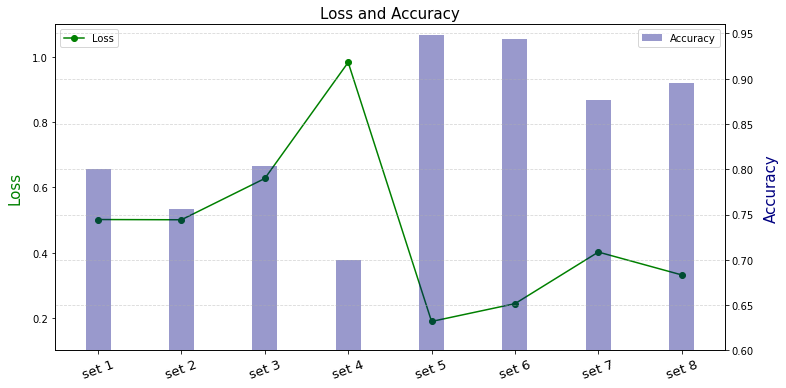

In [ ]:
# loss / acc
plt.figure(figsize=(12,6))

plt.plot( df['loss'], color='green', linewidth=1.5, marker='o', label='Loss')
plt.ylabel('Loss', color='green', labelpad = 10, fontsize=15)
# plt.xlabel('Image Set', fontsize=15)
plt.xticks( rotation = 20, fontsize=13)
plt.ylim(0.1, 1.1)
plt.legend(loc = 'upper left')

ax=plt.gca()
ax2=ax.twinx()

ax2.bar(df.set, df['acc'],alpha=0.4 ,width=0.3, color='navy' , label = 'Accuracy' )
ax2.set_ylabel('Accuracy', color='navy' , labelpad = 10 , fontsize=15)
plt.ylim(0.6, 0.96)
plt.legend(loc = 'upper right')

plt.title('Loss and Accuracy', fontsize=15)
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
plt.show()